In [94]:
from collections import Counter
import os
from glob import glob

from graphviz import Source
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import networkx as nx
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns

import numbers


sns.set_style('white')
sns.set_context('notebook')

def plot_style(figsize=(12, 6), labelsize=20, titlesize=24, ticklabelsize=14, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': False,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)

blue = sns.xkcd_rgb['ocean blue']

In [95]:
def new_count_row(all_clone_names, clone_name=None):
    """ Create a DataFrame row with one entry per clone name. 
    
    If `clone_name` is not None, initialize that entry to 1.
    """
    row = pd.Series(data=0, index=all_clone_names)
    if clone_name is not None:
        row[clone_name] = 1
    return row

def dfs_clones_count(g, clones, all_clone_names, source_node):
    clones_count = pd.DataFrame({sample_name: new_count_row(all_clones, clone_name) for sample_name, clone_name in clones.items()})
    for pre_node, post_node, edge_label in nx.dfs_labeled_edges(g, source_node):
        if edge_label is not 'reverse' or pre_node == post_node: 
            continue
        pre_node_counter = clones_count.get(pre_node, new_count_row(all_clones))
        if post_node not in clones_count.columns:
            #print('!! possible mutation in a leaf: not found', post_node)
            continue
        clones_count[pre_node] = pre_node_counter + clones_count[post_node]

    return clones_count

def purity(clones_count):
    return clones_count.div(clones_count.sum(axis=0), axis=1)

def get_root_node(t):
    root_nodes = [n for n,d in t.in_degree() if d==0]
    assert len(root_nodes) == 1
    root_node = root_nodes[0]
    return root_node

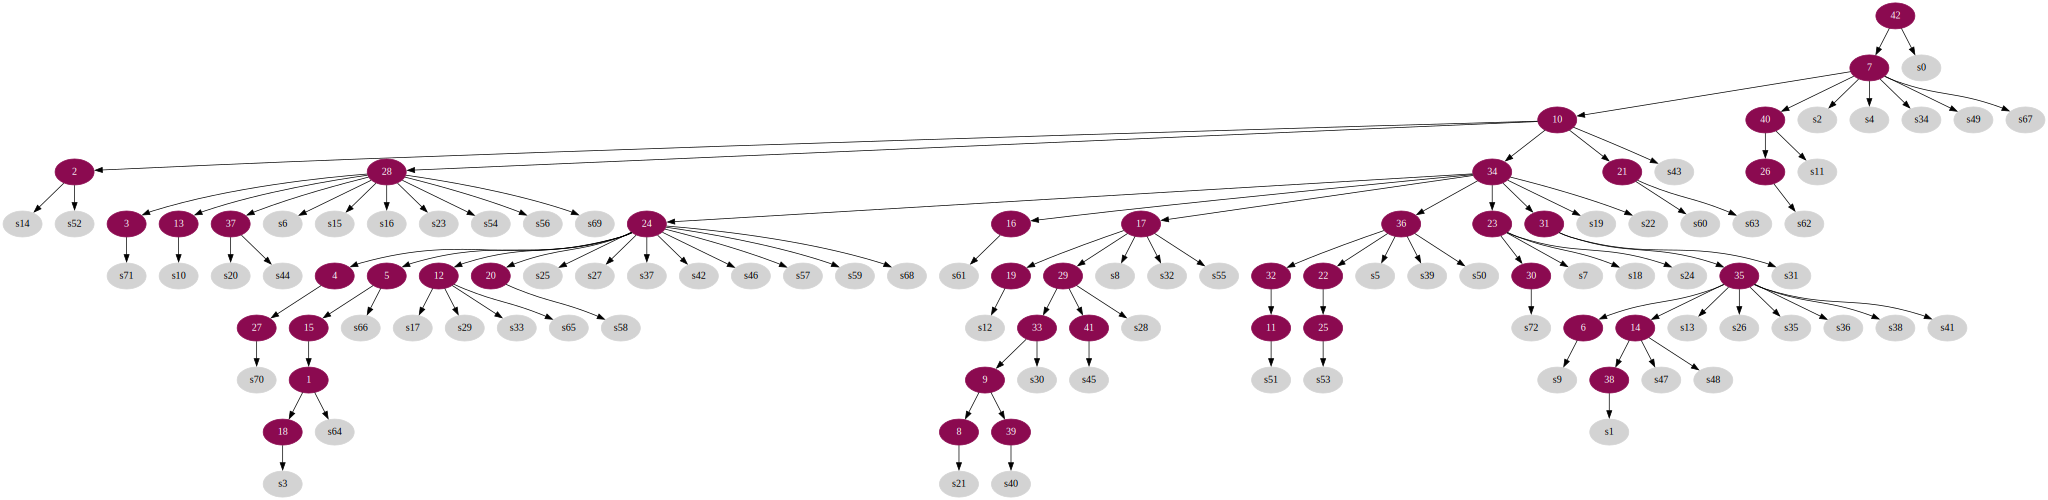

In [29]:
# Plot an example tree
Source.from_file('../../mt-SCITE_output/YFV2001/0.0556/0.0556_map0.gv')

## Clone map

In [41]:
data = pd.read_csv('../../data/YFV2001_clone_key/YFV2001_clone_key', sep = '\t')
data.head()

clones_map_raw = data.copy()

In [72]:
clones_map_raw.clone.value_counts()

149     20
118     18
107     16
122      8
108      6
143      4
bulk     1
Name: clone, dtype: int64

In [73]:
clones_map = dict(clones_map_raw[['tree_id', 'clone']].values)
all_clones = list(clones_map_raw.clone.unique())

In [74]:
n_samples_per_clone = clones_map_raw.clone.value_counts()
n_samples_per_clone

149     20
118     18
107     16
122      8
108      6
143      4
bulk     1
Name: clone, dtype: int64

## Load tree and pmat data

In [75]:
scite_input_path = '../../mt-SCITE_output/YFV2001/stdout/'
scite_stdout_filenames = list(glob(os.path.join(scite_input_path, '*.txt')))
#scite_stdout_filenames


# Get log likelihood scores
experiments = []
lhood = []
n_trees = []
for filename in sorted(scite_stdout_filenames):
    name = os.path.basename(filename).split('-')[0].rsplit('.', 2)[0]
    experiments.append(name)
    experiments = [float(x) for x in experiments]
    file = open(filename, "r")
    for line in file:
        if 'best log score for tree:' in line:
            score = line.split('	')[1].rstrip()
            lhood.append(score)
            lhood = [float(x) for x in lhood]
        if 'opt tree' in line:
            n = line.split(' opt')[0].lstrip()
            n_trees.append(n)
            n_trees = [int(x) for x in n_trees]

In [76]:
experiments

[0.0001,
 0.0112,
 0.0223,
 0.0334,
 0.0445,
 0.0556,
 0.0667,
 0.0778,
 0.0889,
 0.1,
 0.2,
 0.22]

In [77]:
pmat_input_path = '../../data/YFV2001_matrix_output/'
pmats = list(glob(os.path.join(pmat_input_path, '*.csv')))
#pmats

# Get n mutations
n_mut = []
for filename in sorted(pmats):
    file = open(filename, "r")
    n = len(file.readlines())
    n_mut.append(n)

In [78]:
# check n samples 
df = pd.read_csv('../../data/YFV2001_matrix_output/0.0001.csv', sep=' ', header=None)
df.shape

(453, 73)

In [79]:
# Create df
samples = 73
performance = pd.DataFrame(experiments)
performance['lhood'] = lhood
performance['n trees'] = n_trees
performance['n mutations'] = n_mut
performance['lhood'] = performance['lhood'].astype(float)
#tree_data['lhood_mut'] = tree_data['best log score for tree']/tree_data['n mutations']
performance['entries'] = performance['n mutations']*samples
performance['lhood_entries'] = performance['lhood']/performance['entries']
performance = performance.rename(columns={0: 'error_rate'})
performance = performance.set_index('error_rate')
performance

,lhood,n trees,n mutations,entries,lhood_entries
error_rate,,,,,
0.0001,-14347.557804,46,453,33069,-0.433867
0.0112,-2360.839714,4,104,7592,-0.310964
0.0223,-1601.174547,4,63,4599,-0.348157
0.0334,-1192.432366,1,52,3796,-0.314129
0.0445,-925.961387,5,47,3431,-0.269881
0.0556,-839.173063,7,41,2993,-0.280379
0.0667,-832.854042,30,41,2993,-0.278267
0.0778,-816.956066,1,39,2847,-0.286953
0.0889,-818.122960,16,39,2847,-0.287363


In [80]:
error_rates = performance.index.tolist()
n_trees = performance['n trees'].tolist()
error_rates, n_trees

([0.0001,
  0.0112,
  0.0223,
  0.0334,
  0.0445,
  0.0556,
  0.0667,
  0.0778,
  0.0889,
  0.1,
  0.2,
  0.22],
 [46, 4, 4, 1, 5, 7, 30, 1, 16, 1, 2, 1])

In [81]:
MAX_TREES_PER_ERROR_RATE = 2

all_trees = {}
for error_rate, n in zip(error_rates, n_trees):
    all_trees[error_rate] = []
    for idx in range(min(MAX_TREES_PER_ERROR_RATE, n)):
        tree_filename = f'../../mt-SCITE_output/YFV2001/all_dot_files/{error_rate}_map{idx}.gv'
        tree = nx.drawing.nx_pydot.read_dot(tree_filename)
        tree.remove_node('\\n')
        all_trees[error_rate].append(tree)

In [82]:
performance['tree_size'] = 0
for error_rate, trees in all_trees.items():
    n_nodes = [t.number_of_nodes() for t in trees]
    performance.loc[error_rate, 'tree_size'] = np.mean(n_nodes)

In [89]:
performance

,lhood,n trees,n mutations,entries,lhood_entries,tree_size,avg_purity_more_than_one_sample,frac_purity_100_more_than_one_sample
error_rate,,,,,,,,
0.0001,-14347.557804,46,453,33069,-0.433867,527,0.526083,0.072464
0.0112,-2360.839714,4,104,7592,-0.310964,178,0.717320,0.424242
0.0223,-1601.174547,4,63,4599,-0.348157,137,0.640956,0.392857
0.0334,-1192.432366,1,52,3796,-0.314129,126,0.723898,0.360000
0.0445,-925.961387,5,47,3431,-0.269881,121,0.813898,0.625000
0.0556,-839.173063,7,41,2993,-0.280379,115,0.814399,0.695652
0.0667,-832.854042,30,41,2993,-0.278267,115,0.807929,0.681818
0.0778,-816.956066,1,39,2847,-0.286953,113,0.780010,0.565217
0.0889,-818.122960,16,39,2847,-0.287363,113,0.788362,0.666667


In [85]:
t = all_trees[0.0001][0]

In [86]:
clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
clones_count

,s0,s10,s54,s55,s56,s62,s67,s69,s71,s6,...,307,410,247,326,428,321,31,454,412,175
bulk,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
107,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,15,16,1,1
108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,6,0,0
118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,18,18,0,0
122,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,8,8,0,0
143,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,4,0,0
149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,20,20,0,0


In [87]:
p = purity(clones_count)
p = p[[c for c in p.columns if c not in clones_map.keys()]]
p

,121,62,130,12,375,324,225,44,311,74,...,307,410,247,326,428,321,31,454,412,175
bulk,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.013699,0.0,0.0
107,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,...,1.0,1.0,1.0,1.0,1.0,1.0,0.211268,0.219178,1.0,1.0
108,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.084507,0.082192,0.0,0.0
118,0.0,0.666667,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.257143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.253521,0.246575,0.0,0.0
122,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.114286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.112676,0.109589,0.0,0.0
143,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.056338,0.054795,0.0,0.0
149,1.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.281690,0.273973,0.0,0.0


# Avg purity of nodes with >1 sample

In [88]:
performance['avg_purity_more_than_one_sample'] = 0
performance['frac_purity_100_more_than_one_sample'] = 0
for error_rate, trees in all_trees.items():
    avg_purities = []
    frac_purities_100 = []
    n_purities_100 = []
    for t in trees:
        print(error_rate, get_root_node(t))
        clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
        more_than_one_sample = clones_count.sum(axis=0) > 1
        p = purity(clones_count).loc[:, more_than_one_sample]
        # Average purity
        avg_purity = p.max(axis=0).mean()
        avg_purities.append(avg_purity)
        # Fraction of nodes with 100% purity
        is_purity_100 = np.isclose(p.max(axis=0), 1.0)
        frac_purity_100 = is_purity_100.sum() / is_purity_100.shape[0]
        frac_purities_100.append(frac_purity_100)

    performance.loc[error_rate, 'avg_purity_more_than_one_sample'] = avg_purities[0]
    performance.loc[error_rate, 'frac_purity_100_more_than_one_sample'] = frac_purities_100[0]

0.0001 454
0.0001 454
0.0112 105
0.0112 105
0.0223 64
0.0223 64
0.0334 53
0.0445 48
0.0445 48
0.0556 42
0.0556 42
0.0667 42
0.0667 42
0.0778 40
0.0889 40
0.0889 40
0.1 39
0.2 11
0.2 11
0.22 6


# Clone coverage at full purity

In [90]:
performance['min_clone_coverage'] = np.nan
performance['avg_clone_coverage'] = np.nan
for error_rate, trees in all_trees.items():
    t = trees[0]

    clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
    p = purity(clones_count)
    is_pure = p.max(axis=0) == 1.0
    coverage_per_clone = clones_count.loc[:, is_pure].div(n_samples_per_clone, axis=0).max(axis=1)
    print(error_rate, '\n', coverage_per_clone, '\n---')
    min_coverage = coverage_per_clone.min()
    avg_coverage = coverage_per_clone.drop('bulk').mean()
    performance.loc[error_rate, 'min_clone_coverage'] = min_coverage
    performance.loc[error_rate, 'avg_clone_coverage'] = avg_coverage

0.0001 
 107     0.062500
108     0.166667
118     0.055556
122     0.250000
143     0.250000
149     0.100000
bulk    1.000000
dtype: float64 
---
0.0112 
 107     0.562500
108     0.833333
118     0.111111
122     0.250000
143     0.500000
149     0.400000
bulk    1.000000
dtype: float64 
---
0.0223 
 107     0.312500
108     0.500000
118     0.444444
122     0.375000
143     0.500000
149     0.400000
bulk    1.000000
dtype: float64 
---
0.0334 
 107     0.500000
108     0.833333
118     0.111111
122     0.125000
143     1.000000
149     0.350000
bulk    1.000000
dtype: float64 
---
0.0445 
 107     0.750000
108     0.833333
118     0.222222
122     0.250000
143     1.000000
149     0.700000
bulk    1.000000
dtype: float64 
---
0.0556 
 107     0.687500
108     0.833333
118     0.944444
122     0.625000
143     1.000000
149     0.550000
bulk    1.000000
dtype: float64 
---
0.0667 
 107     0.625000
108     0.833333
118     0.944444
122     0.625000
143     1.000000
149     0.700000
b

# Pure nodes per clone

In [58]:
import warnings
warnings.filterwarnings('ignore')

data = [0, 1, 2, 3, 4, 5, 6]
df = pd.DataFrame(data, columns=['Numbers'])
df = df.set_index('Numbers')


for error_rate, trees in all_trees.items():

    for t in trees:
        error_rate = error_rate
        clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
        more_than_one_sample = clones_count.sum(axis=0) > 1
        p = purity(clones_count).loc[:, more_than_one_sample]
        purities = p.T.apply(pd.value_counts).fillna(0)
        pure_nodes = purities.iloc[-1]
        pure_nodes = pure_nodes.reset_index()
        pure_nodes.columns = ['clone', str(error_rate)]
        df = pd.concat([df, pure_nodes], axis=1)

index = df.iloc[:, 0].tolist()
df.index = index

# remove duplicate clone columns 
df = df.drop(df.filter(regex='clone').columns, axis=1)

# get mean of columns with the same name
# https://stackoverflow.com/questions/40311987/pandas-mean-of-columns-with-the-same-names
n_purities = df.groupby(by=df.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


# get error rates with an average purity > 70%
good_error_rates = performance.query('avg_purity_more_than_one_sample > 0.75').index.to_list()

# get only these columns
good_error_rates = [str(x) for x in good_error_rates]
n_purities_good_error_rates = n_purities[good_error_rates]

# get the average number of mutations per clone
n_purities_good_error_rates['mean_pure_nodes_clone'] = n_purities_good_error_rates.mean(axis=1)

# remove bulk
n_purities_good_error_rates = n_purities_good_error_rates.iloc[1: , :]

# Average number of clone specific mutations
n_purities_good_error_rates["mean_pure_nodes_clone"].mean()

2.388888888888889

In [59]:
n_purities_good_error_rates

,0.0445,0.0556,0.0667,0.0778,0.0889,0.1,mean_pure_nodes_clone
107,2.0,2.0,2.0,1.0,1.0,1.0,1.500000
108,3.0,3.0,3.0,3.0,3.0,2.0,2.833333
118,4.0,5.0,5.0,4.0,5.0,5.0,4.666667
122,2.0,1.0,1.0,1.0,1.0,1.0,1.166667
143,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
149,3.0,4.0,3.0,3.0,3.0,3.0,3.166667


In [60]:
# Prepare df for plotting
hej = n_purities_good_error_rates.copy()

hej = hej.drop('mean_pure_nodes_clone', axis=1)
hej = hej.T

hej

,107,108,118,122,143,149
0.0445,2.0,3.0,4.0,2.0,1.0,3.0
0.0556,2.0,3.0,5.0,1.0,1.0,4.0
0.0667,2.0,3.0,5.0,1.0,1.0,3.0
0.0778,1.0,3.0,4.0,1.0,1.0,3.0
0.0889,1.0,3.0,5.0,1.0,1.0,3.0
0.1,1.0,2.0,5.0,1.0,1.0,3.0


# Plots

In [61]:
performance

,lhood,n trees,n mutations,entries,lhood_entries,tree_size,avg_purity_more_than_one_sample,frac_purity_100_more_than_one_sample,min_clone_coverage,avg_clone_coverage
error_rate,,,,,,,,,,
0.0001,-14347.557804,46,453,33069,-0.433867,527,0.526083,0.072464,0.055556,0.147454
0.0112,-2360.839714,4,104,7592,-0.310964,178,0.717320,0.424242,0.111111,0.442824
0.0223,-1601.174547,4,63,4599,-0.348157,137,0.640956,0.392857,0.312500,0.421991
0.0334,-1192.432366,1,52,3796,-0.314129,126,0.723898,0.360000,0.111111,0.486574
0.0445,-925.961387,5,47,3431,-0.269881,121,0.813898,0.625000,0.222222,0.625926
0.0556,-839.173063,7,41,2993,-0.280379,115,0.814399,0.695652,0.550000,0.773380
0.0667,-832.854042,30,41,2993,-0.278267,115,0.807929,0.681818,0.625000,0.787963
0.0778,-816.956066,1,39,2847,-0.286953,113,0.780010,0.565217,0.166667,0.647917
0.0889,-818.122960,16,39,2847,-0.287363,113,0.788362,0.666667,0.500000,0.724074


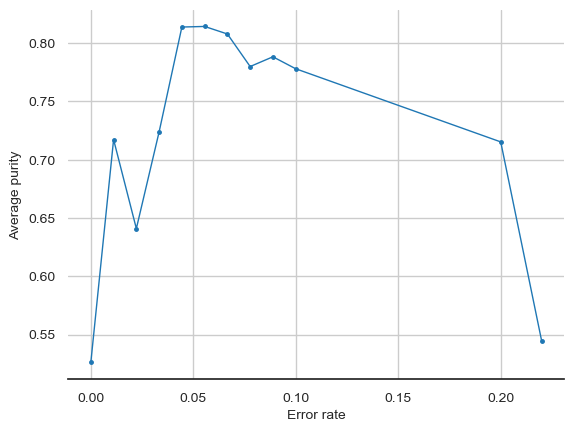

In [98]:
plt.figure()
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.avg_purity_more_than_one_sample.plot(marker='o', markersize=2.5, lw=1)
    plt.grid(axis='both')
    #plt.xscale('log')
    plt.xlabel('Error rate')
    plt.ylabel('Average purity')
    plt.savefig('../../data/YFV2001_figures/avg_purity.svg', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig('../../data/YFV2001_figures/avg_purity.jpg', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

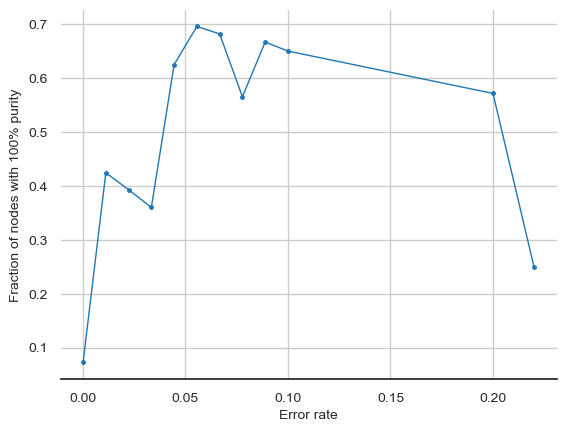

In [99]:
plt.figure()
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.frac_purity_100_more_than_one_sample.plot(marker='o', markersize=2.5, lw=1)
    plt.grid(axis='both')
    plt.xlabel('Error rate')
    plt.ylabel('Fraction of nodes with 100% purity')
    plt.savefig('../../data/YFV2001_figures/frac_purity.svg', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig('../../data/YFV2001_figures/frac_purity.jpg', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

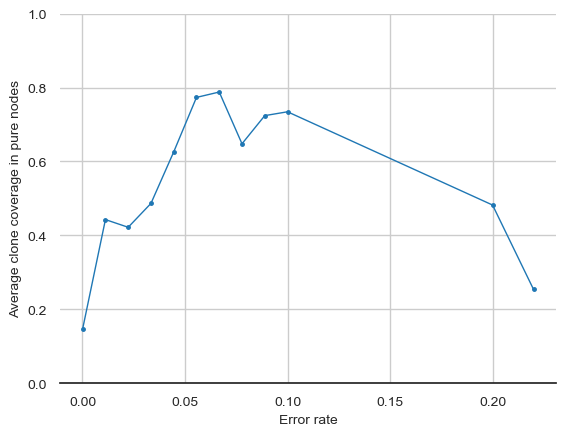

In [100]:
plt.figure()
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.avg_clone_coverage.plot(marker='o', markersize=2.5, lw=1)
    plt.grid(axis='both')
    plt.ylim(0, 1)
    plt.xlabel('Error rate')
    plt.ylabel('Average clone coverage in pure nodes')
    plt.savefig('../../data/YFV2001_figures/clone_cov.svg', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig('../../data/YFV2001_figures/clone_cov.jpg', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

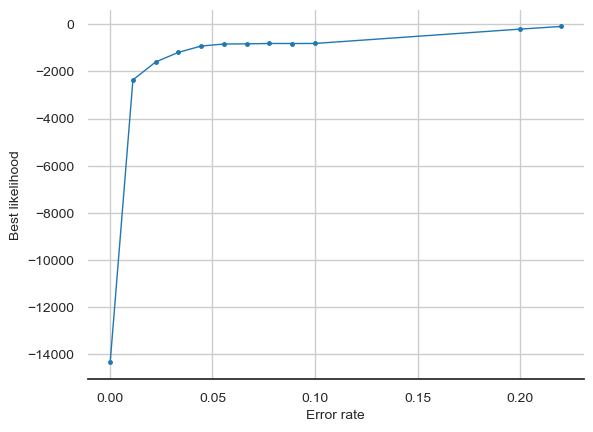

In [101]:
plt.figure()
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.lhood.plot(marker='o', markersize=2.5, lw=1)
    plt.grid(axis='both')
    plt.xlabel('Error rate')
    plt.ylabel('Best likelihood')
    plt.savefig('../../data/YFV2001_figures/lhood.svg', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig('../../data/YFV2001_figures/lhood.jpg', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

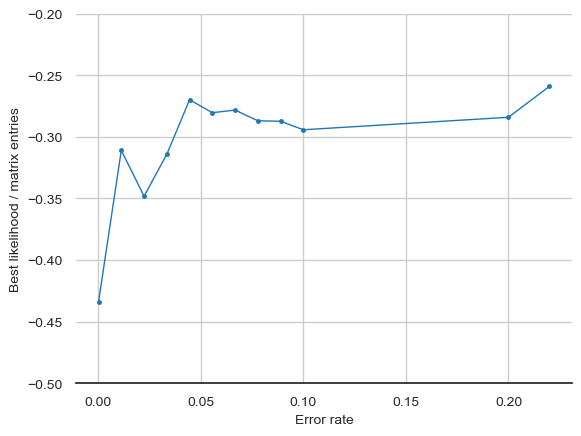

In [102]:
plt.figure()
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.lhood_entries.plot(marker='o', markersize=2.5, lw=1)
    plt.grid(axis='both')
    #plt.xscale('log')
    plt.ylim(-0.5, -0.2)
    plt.xlabel('Error rate')
    plt.ylabel('Best likelihood / matrix entries')
    plt.savefig('../../data/YFV2001_figures/lhood_entries.svg', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig('../../data/YFV2001_figures/lhood_entries.jpg', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

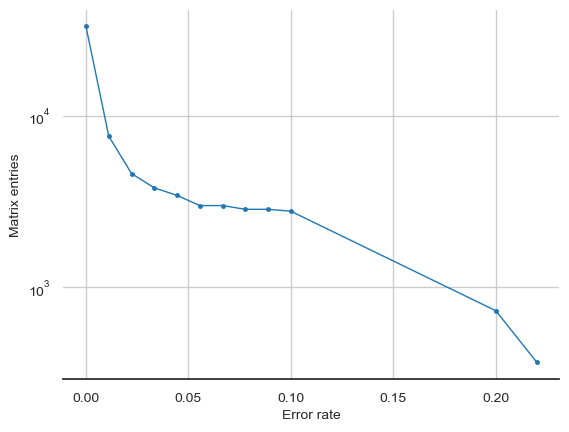

In [103]:
plt.figure()
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.entries.plot(marker='o', markersize=2.5, lw=1)
    plt.grid(axis='both')
    plt.yscale('log')
    plt.xlabel('Error rate')
    plt.ylabel('Matrix entries')
    plt.savefig('../../data/YFV2001_figures/entries.svg', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig('../../data/YFV2001_figures/entries.jpg', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

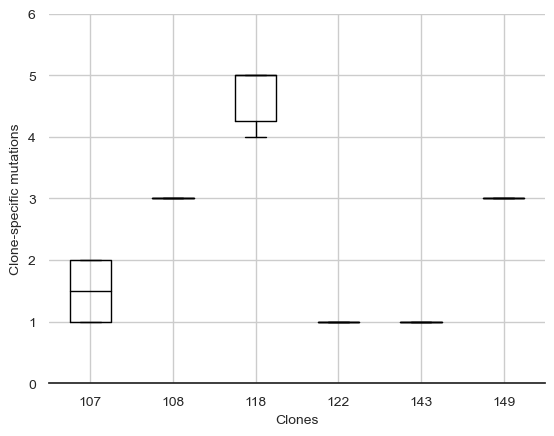

In [104]:
# Clone specific mutations
plt.figure()
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    plt.grid(axis='both')
    #plt.xscale('log')
    plt.xlabel('Clones')
    plt.ylabel('Clone-specific mutations')
    plt.ylim(0, 6)

    vals, names, xs = [],[],[]
    for i, col in enumerate(hej.columns):
        vals.append(hej[col].values)
        names.append(col)
        xs.append(np.random.normal(i + 1, 0.01, hej[col].values.shape[0]))  # adds jitter to the data points
    #print(names)

    boxplot = plt.boxplot(vals, labels=names, showfliers=False)# patch_artist=True)

    palette = ['#E5715F', '#F2C381', '#6C85B6', '#91CFCF', '#978CB7', '#BAD99F'] # #F2C381 and #BAD99F are swapped compared to P9855
    
    for median in boxplot['medians']:
        median.set_color('black')
    #for x, val, c in zip(xs, vals, palette):
        #plt.scatter(x, val, alpha=0.8, color=c, marker='s', s=40)  
        
    plt.savefig('../../data/YFV2001_figures/n_clone_muts.svg', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig('../../data/YFV2001_figures/n_clone_muts.jpg', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()